In [1]:
import psycopg2
import pandas as pd

# Connect to the database
conn = psycopg2.connect(
    host='localhost',
    port=5432,
    dbname='mydb',
    user='myuser',
    password='mypass'
)


# Create a cursor
cursor = conn.cursor()

# Extract data from the sales table
cursor.execute("SELECT * FROM sales")
sales_data = cursor.fetchall()
# Close the cursor and connection
cursor.close()
conn.close()


In [2]:
# Create a DataFrame from the query results
df = pd.DataFrame(sales_data, columns=['title', 'price', 'amount', 'payment_method', 'client', 'time_added'])
df['week_day'] = df['time_added'].dt.weekday
df['date'] = df['time_added'].dt.date
df['month'] = df['time_added'].dt.month

In [3]:
# The following lines should be added after 'df['date'] = df['time_added'].dt.date' 
df = df.groupby(['date', 'week_day', 'month']).agg({'price':'sum', 'client':'nunique'}).reset_index()
df.rename(columns={'price':'daily_income', 'client':'unique_visitors'}, inplace=True)

df = pd.read_csv('./data.csv')

,date,week_day,month,daily_income,unique_visitors
0,2019-07-19,4,7,100.0,1
1,2019-07-20,5,7,660.0,3
2,2019-07-21,6,7,2100.0,8
3,2019-07-22,0,7,1650.0,5
4,2019-07-23,1,7,1050.0,4
...,...,...,...,...,...
1126,2023-01-14,5,1,4860.0,9
1127,2023-01-15,6,1,4800.0,10
1128,2023-01-16,0,1,3400.0,7
1129,2023-01-17,1,1,1600.0,6


# Plot relationships

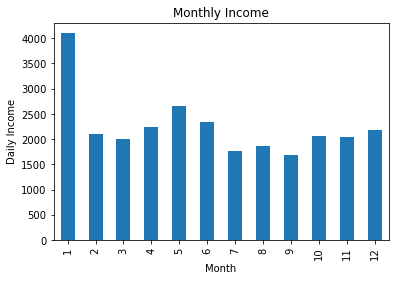

In [4]:
import matplotlib.pyplot as plt

df_monthly = df.groupby('month')['daily_income'].mean()

df_monthly.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Daily Income')
plt.title('Monthly Income')
plt.show()


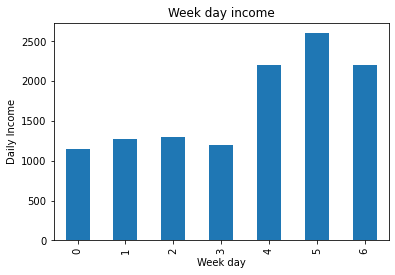

In [5]:
df_daily = df.groupby('week_day')['daily_income'].median()
df_daily.plot(kind='bar')

plt.xlabel('Week day')
plt.ylabel('Daily Income')
plt.title('Week day income')
plt.show()

# Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# select features and target
X = df[['week_day','month','unique_visitors']]
y = df['daily_income']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# evaluate the model on the test data
score = model.score(X_test, y_test)
print("Test score: ", score)

# make a prediction for the next day
next_day_features = [[6,1,10]] #6 is saturday, 1 is January, 100 is number of unique visitors
next_day_income = model.predict(next_day_features)
print("Predicted income for the next day: ", next_day_income)


Test score:  0.34870581282839286
Predicted income for the next day:  [5112.31944205]


/home/gnome/miniconda3/envs/pp/lib/python3.11/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [29]:

import pickle
filename = 'linear_regression_model.pkl'
pickle.dump(model, open(filename, 'wb'))


In [30]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(next_day_features)
print(result)

[5112.31944205]


/home/gnome/miniconda3/envs/pp/lib/python3.11/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# Gradient Boosting

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# select features and target
X = df[['week_day','month','unique_visitors']]
y = df['daily_income']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5]
}

# create the model
model = GradientBoostingRegressor()

# perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

# evaluate the model on the test data
score = grid_search.score(X_test, y_test)
print("Test score: ", score)

# make a prediction for the next day
next_day_features = [[3,4,10]] #6 is saturday, 1 is January, 100 is number of unique visitors
next_day_income = grid_search.predict(next_day_features)
print("Predicted income for the next day: ", next_day_income)


Test score:  0.37233148020258333
Predicted income for the next day:  [3996.49276014]


/home/gnome/miniconda3/envs/pp/lib/python3.11/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [23]:
from joblib import dump

dump(grid_search.best_estimator_, 'model.pkl')


['model.pkl']

# Random forest regressor

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

# select features and target
X = df[['week_day','month','unique_visitors']]
y = df['daily_income']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# create the model
model = RandomForestRegressor()

# perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

# evaluate the model on the test data
score = grid_search.score(X_test, y_test)
print("Test score: ", score)

# make a prediction for the next day
next_day_features = [[6,1,6]]
next_day_income = grid_search.predict(next_day_features)
print("Predicted income for the next day: ", next_day_income)


KeyboardInterrupt: 

In [ ]:
df.to_csv('data.csv')